**РК2**

**ФИО: Бабин В.Е.**

**Группа: ИУ5-22М**

**Вариант: 1**

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import requests
import io
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_boston

In [104]:
# по варианту набор данных о ценах на жилье в Бостоне
data = load_boston()

# преобразовали к таблице
columns = data['feature_names']
data = data['data']
table_basic = dict()
for j in range(len(columns)):
    table_basic[columns[j]] = [data[i][j] for i in range(len(data))]

data = pd.DataFrame(table_basic, index=range(len(data)))
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


**Будем решать задачу регрессии для признака TAX (Налоговая ставка на имущество на 10 000 долларов США)**

In [105]:
data.shape

(506, 13)

**Обработка пропусков в данных**

In [106]:
# пропуски в данных
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

**Выбор признаков для посроения модели**

In [107]:
# типы данных
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [108]:
# выберем числовые признаки
cols_to_check = []
for column in data.columns:
    dt = str(data[column].dtype)
    if dt == 'int64' or dt == 'float64':
        cols_to_check.append(column)
cols_to_check

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

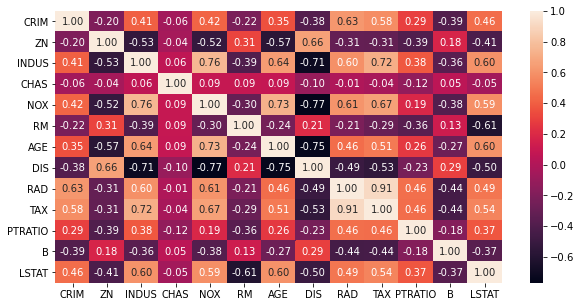

In [109]:
# определим, какие из признаков более всего связаны (коррелируют) с выбранным целевым признаком
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[cols_to_check].corr(), annot=True, fmt='.2f')

In [111]:
# больше всего на налоговую стоимость TAX влияют следующие признаки:
# RAD, INDUS и NOX (также можно взять AGE)
most_corr = ['RAD', 'INDUS', 'NOX', 'AGE']

**Будем использовать следующие метрики:**

1)Mean absolute error (MAE) - средняя абсолютная ошибка

2)Mean squared error (MSQ) - средняя квадратичная ошибка

3)Метрика R2 или коэффициент детерминации

In [112]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

**Разбиение на тестовую и обучающую выборки**

In [119]:
# Разделение выборки на обучающую и тестовую
regr_X_train, regr_X_test, regr_Y_train, regr_Y_test = train_test_split(
    data[most_corr], data['TAX'], test_size=0.3, random_state=1)
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((354, 4), (152, 4), (354,), (152,))

**Для решениязадачи регресии будем использовать модели:**

1)Случайный лес (RandomForestRegressor)

2)Градиентный бустинг (GradientBoostingRegressor)

In [120]:
regr_models = {'RandomForestRegressor':RandomForestRegressor(),
               'GradientBoostingRegressor':GradientBoostingRegressor()}

regrMetricLogger = MetricLogger()

def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [121]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE=12.467, MSE=1247.314, R2=0.954
*****************************************************
*****************************************************
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
   

**Сделаем выводы о качестве полученных моделей**

In [122]:
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

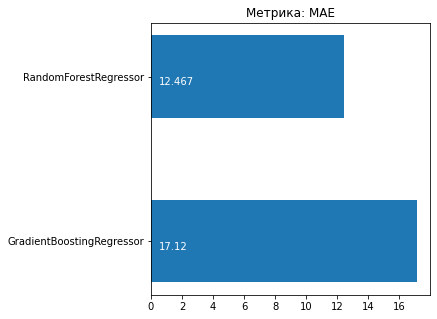

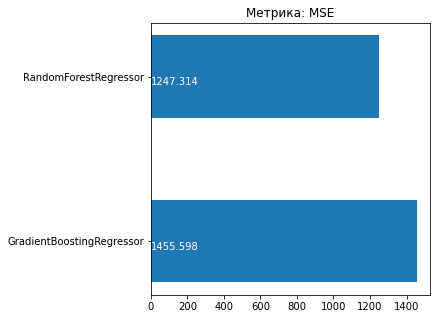

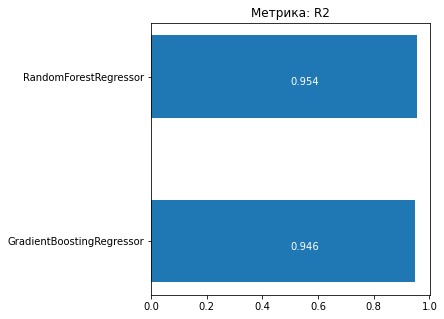

In [123]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(5, 5))
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(5, 5))
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(5, 5))

**Из полученных графиков можно сделать вывод, что в контексте данной задачи модель случайного леса является лучше, чем модель градиентного бустинга**

Так как средняя абсолютная и средняя квадратичные ошибки получились меньше, чем у модели градиентного бустинга, а коэффициент детерменизации больше